In [1]:
import numpy
from scipy import stats
from matplotlib import pyplot as plot
import pandas
from statsmodels.sandbox.stats.multicomp import multipletests
%matplotlib inline

In [2]:
wine = pandas.read_csv('wine.data', header=None)
samples = []

samples.append(pandas.read_csv('slump_test.data')['Compressive Strength (28-day)(Mpa)'].values)
samples.append(numpy.loadtxt('vowel-context.data').T[6])
samples.append(wine.iloc[:, 4].values)
samples.append(wine.iloc[:, 1].values)
samples.append(wine.iloc[:, 3].values)
samples.append(wine.iloc[:, 8].values)
samples.append(wine.iloc[:, 9].values)

Посмотрим на корреляцию некоторых выборок. Если они окажутся слишком зависимыми, использовать метод Бенджамини-Хохберга будет нельзя.

In [3]:
test_data = numpy.array(samples[2:])
pandas.DataFrame(test_data.T).corr()

,0,1,2,3,4
0,1.000000,-0.310235,0.443367,0.361922,-0.197327
1,-0.310235,1.000000,0.211545,-0.155929,0.136698
2,0.443367,0.211545,1.000000,0.186230,0.009652
3,0.361922,-0.155929,0.186230,1.000000,-0.365845
4,-0.197327,0.136698,0.009652,-0.365845,1.000000


Между некоторыми выборками корреляция получилась болшой. Вместо Бенджамини-Хохберга будем использовать Бенджамини-Иекутиели.

In [4]:
methods = [
    (lambda sample: stats.shapiro(sample)[1]),
    (lambda sample: 
        stats.kstest(
            sample, lambda x: stats.norm.cdf(
                x, loc=stats.norm.fit(sample)[0],
                scale=stats.norm.fit(sample)[1]
            )
        )[1]
    ),
    (lambda sample: stats.jarque_bera(sample)[1]),
    (lambda sample: stats.skewtest(sample)[1])
]

In [5]:
p_values = []
for i in range(len(samples)):
    for j in range(len(methods)):
        p_values.append((i, j, methods[j](samples[i])))
p_values = numpy.array(p_values)
answers = multipletests(p_values[:,2], method="fdr_by", alpha=0.05)[0]

Буем принимать гипотезу, если нет критериев, которые ее отвергли. Посмотрим на гистограмки и результаты.

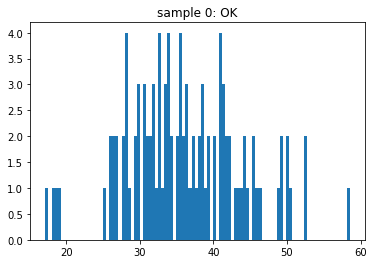

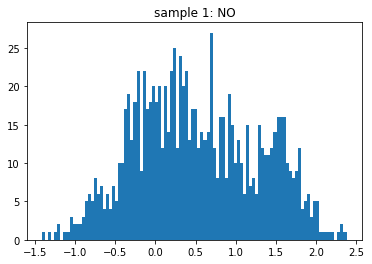

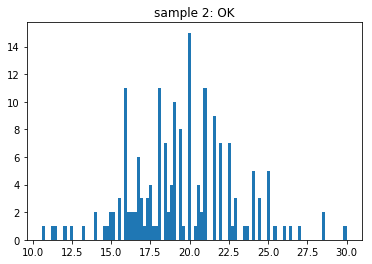

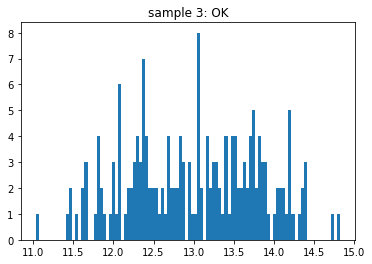

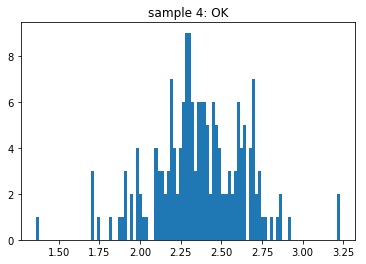

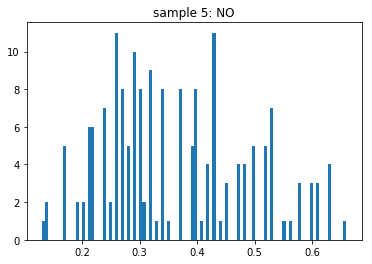

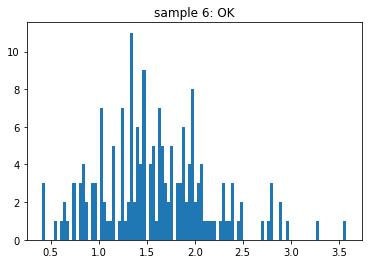

In [6]:
for sample_index, sample in enumerate(samples):
    plot.figure()
    plot.hist(sample, bins=100)
    plot.title(
        "sample {}: {}".format(sample_index, "OK" if all([
            not answer for answer_sample_index, answer in zip(p_values[:,0], answers)
            if sample_index == answer_sample_index
        ]) else "NO")
    )

5 из 7 выборок можно считать нормальными.